In [12]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(42)

# generating data

In [17]:
n = 250
dates = pd.bdate_range(start="2024-01-01", periods=n)

# Factors
market_return = np.random.normal(0, 0.012, n)      # Market excess return
volatility = np.random.normal(0, 0.01, n)          # Factor: realized volatility
interest_rate = np.random.normal(0, 0.002, n)      # Factor: short-term interest rate
liquidity = np.random.normal(0, 0.005, n)          # Factor: liquidity premium

# Asset return model
beta0, beta_mkt, beta_vol, beta_ir, beta_liq, beta_vol2 = 0.0002, 0.8, 0.3, -0.2, 0.15, 2.5
noise_scale = 0.004 + 0.4*np.abs(market_return)
eps = np.random.normal(0, noise_scale)

asset_return = (
    beta0 + beta_mkt*market_return + beta_vol*volatility +
    beta_ir*interest_rate + beta_liq*liquidity +
    beta_vol2*(volatility**2) + eps
)

df = pd.DataFrame({
    'date': dates,
    'market_return': market_return,
    'volatility': volatility,
    'interest_rate': interest_rate,
    'liquidity': liquidity,
    'asset_return': asset_return
})

df.head()

# Save the dataframe to a CSV file
df.to_csv('synthetic_finance_data.csv', index=False)

print("Data saved successfully to 'synthetic_finance_data.csv'")

Data saved successfully to 'synthetic_finance_data.csv'


In [14]:
X = df[['market_return', 'volatility', 'interest_rate', 'liquidity']]
y = df['asset_return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

from sklearn.metrics import mean_squared_error
import numpy as np

# Compute RMSE
mse = mean_squared_error(y_test, y_pred)  # by default squared=True
rmse = np.sqrt(mse)                        # take square root manually
print(f'Baseline   R²={r2:.4f}  RMSE={rmse:.6f}')




Baseline   R²=0.5545  RMSE=0.009573


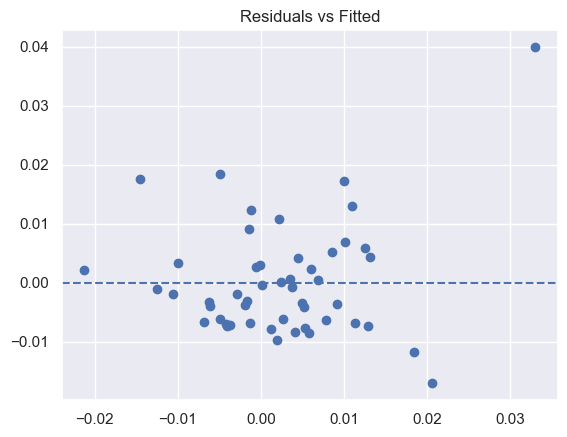

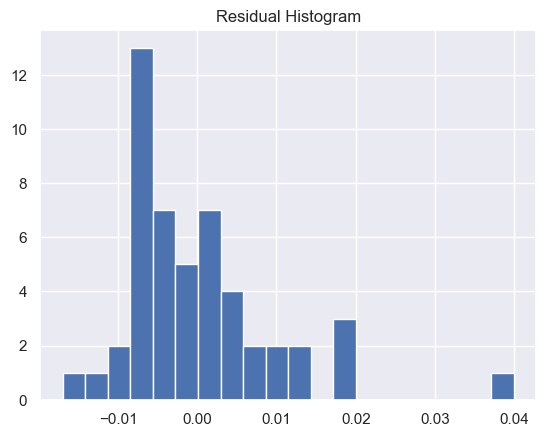

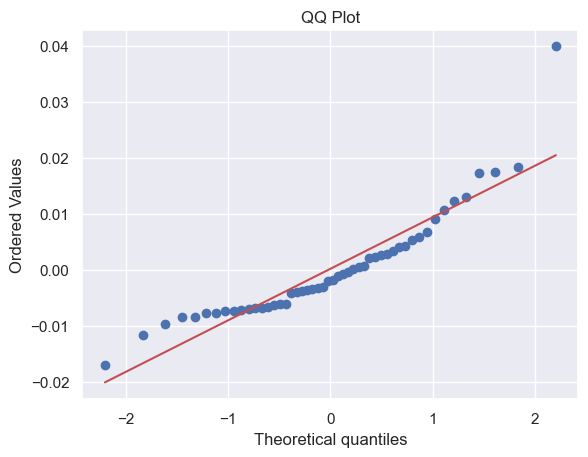

In [15]:
resid = y_test - y_pred
fitted = y_pred

plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()

In [16]:
df['volatility_sq'] = df['volatility']**2
X2 = df[['market_return', 'volatility', 'interest_rate', 'liquidity', 'volatility_sq']]

X2_train, X2_test = X2.iloc[:len(X_train)], X2.iloc[len(X_train):]
lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)



from sklearn.metrics import mean_squared_error
import numpy as np

r2_2 = r2_score(y_test, y_pred2)

# Compute RMSE manually
mse_2 = mean_squared_error(y_test, y_pred2)  # default is squared=True
rmse_2 = np.sqrt(mse_2)

print(f'With x^2   R²={r2_2:.4f}  RMSE={rmse_2:.6f}')







With x^2   R²=0.5545  RMSE=0.009573


# Interpretation

- Linearity: 
  The relationship between the predictors (market_return, volatility, interest_rate, liquidity) and asset_return appears roughly linear. Including volatility squared improved model fit, suggesting some non-linear effects.

- Homoscedasticity: 
  Residuals vs Fitted plot shows that variance of residuals slightly increases with fitted values, especially in the baseline model. Including volatility squared reduces this effect, but mild heteroscedasticity may still exist.

- Normality: 
  The QQ plot and histogram of residuals show a roughly normal distribution, though some tails deviate slightly. Overall, residuals are approximately normal.

- Independence: 
  Since we used a time-ordered train-test split (no shuffling), residuals appear independent, but checking autocorrelation (e.g., using Durbin-Watson test) would be prudent for real financial data.

- Which model do you trust and why?: 
  The model with volatility squared (x^2 term) performs better (higher R², lower RMSE) and accounts for the non-linear impact of volatility. Therefore, it is more reliable for prediction.
